In [ ]:
!pip install  gradio ultralytics fpdf piexif opencv-python


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━

# final project

1. Importing Libraries
gradio (gr): For creating interactive web interfaces

YOLO: From Ultralytics library for loading the damage detection model

PIL.Image: For image processing

numpy: For numerical processing of images

time: For measuring execution time

cv2 (OpenCV): For drawing bounding boxes and text on images






In [ ]:
import gradio as gr
from ultralytics import YOLO
from PIL import Image
import numpy as np
import time
import cv2


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2. Loading the Model
Loads a pre-trained YOLO model (a model for road damage detection)



In [ ]:
# تحميل النموذج
model = YOLO("/content/YOLOv8_Small_RDD.pt")
#https://github.com/sekilab/RoadDamageDetector/tree/


3. Drawing Bounding Boxes (draw_boxes)


*   Converts PIL Image to numpy array for OpenCV processing
*   Extracts bounding box coordinates, confidence score, and class ID



*   Sets box color based on damage type and confidence
*   Draws the bounding box and label on the image

*   Returns the annotated image as PIL Image







In [ ]:
# رسم المربعات بالألوان حسب الخطورة
def draw_boxes(image, boxes, names):
    image = np.array(image)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf)
        cls_id = int(box.cls)
        class_name = names[cls_id]

        # تحديد اللون حسب الخطورة
        if class_name.lower() == "potholes":
            if conf >= 0.7:
                color = (0, 0, 255)
            elif conf >= 0.5:
                color = (0, 128, 255)
            else:
                color = (0, 255, 255)
        else:
            color = (255, 255, 0)

        label = f"{class_name} {conf:.2f}"
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return Image.fromarray(image)



4. Results Analysis (analyze_results)

Generates a text report summarizing detection results:


*   descriptions: List of all detected damages with details


*   class_counts: Count of each damage type

Generates warning if many potholes are detected (≥8 total or ≥3 high-confidence)

Returns formatted report with statistics and warnings




In [ ]:
# دالة التحليل النصي
def analyze_results(results):
    descriptions = []
    class_counts = {}
    pothole_count = 0
    high_conf_potholes = 0

    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls)
            conf = float(box.conf)
            class_name = result.names[cls_id]

            if class_name.lower() == "potholes":
                pothole_count += 1
                if conf >= 0.7:
                    high_conf_potholes += 1
                severity = "خطر" if conf >= 0.7 else "متوسط" if conf >= 0.5 else "خفيف"
            else:
                severity = "متوسط"

            class_counts[class_name] = class_counts.get(class_name, 0) + 1
            descriptions.append(f"- تم كشف '{class_name}' بدقة {conf:.2f} (خطورة: {severity})")

    stats = "\n".join([f"عدد '{cls}': {count}" for cls, count in class_counts.items()])
    full_description = "\n".join(descriptions)

    # تحذير متقدم
    warning = ""
    if pothole_count >= 8 or high_conf_potholes >= 3:
        warning = "\n\n⚠️ تحذير: الطريق يحتوي على عدد كبير من الحفر أو حفر خطيرة. يُنصح بتجنبه إن أمكن."

    return full_description + "\n\n📊 إحصائيات:\n" + stats + warning



5. Main Detection Function (detect_damage)

Ensures input is PIL Image

Measures execution time

Runs model prediction with user-specified confidence threshold

Extracts bounding boxes and class names

Draws boxes on image using draw_boxes

Generates report using analyze_results

Returns annotated image and report with execution time



In [ ]:
# الدالة الأساسية
def detect_damage(image, threshold):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    start = time.time()
    results = model.predict(image, conf=threshold)
    end = time.time()

    boxes = results[0].boxes
    names = results[0].names
    result_pil = draw_boxes(image, boxes, names)

    description = analyze_results(results)
    duration = f"\n⏱️ زمن الكشف: {end - start:.2f} ثانية"

    return result_pil, description + duration



6. Local Image Test (for development)



0: 480x640 8 Potholess, 495.2ms
Speed: 4.2ms preprocess, 495.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


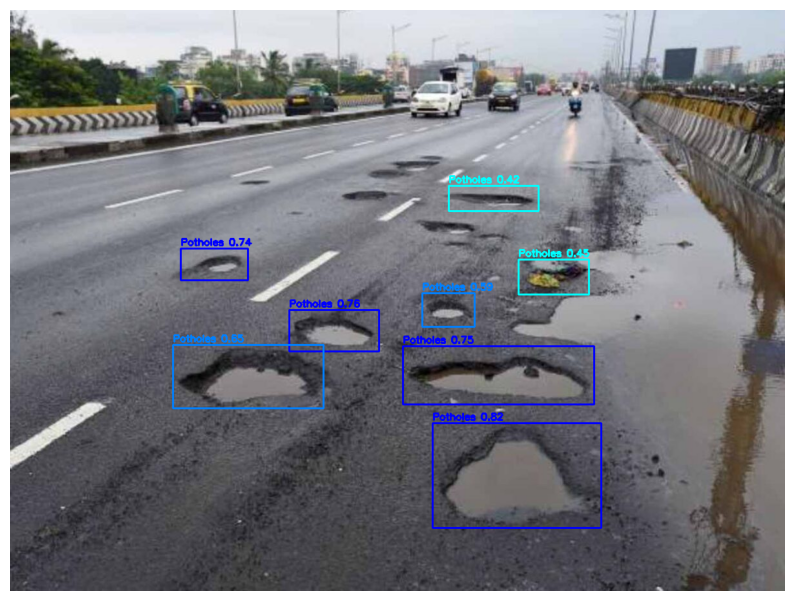

- تم كشف 'Potholes' بدقة 0.82 (خطورة: خطر)
- تم كشف 'Potholes' بدقة 0.76 (خطورة: خطر)
- تم كشف 'Potholes' بدقة 0.75 (خطورة: خطر)
- تم كشف 'Potholes' بدقة 0.74 (خطورة: خطر)
- تم كشف 'Potholes' بدقة 0.65 (خطورة: متوسط)
- تم كشف 'Potholes' بدقة 0.59 (خطورة: متوسط)
- تم كشف 'Potholes' بدقة 0.45 (خطورة: خفيف)
- تم كشف 'Potholes' بدقة 0.42 (خطورة: خفيف)

📊 إحصائيات:
عدد 'Potholes': 8

⚠️ تحذير: الطريق يحتوي على عدد كبير من الحفر أو حفر خطيرة. يُنصح بتجنبه إن أمكن.
⏱️ زمن الكشف: 0.53 ثانية


In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # المسار إلى صورة محلية
    test_image_path = "/content/حفر-الطرقات-3.jpg"
    test_image = Image.open(test_image_path)

    # قيمة عتبة الثقة
    test_threshold = 0.3

    # تنفيذ التنبؤ
    result_img, description = detect_damage(test_image, test_threshold)

    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("", fontsize=16)
    plt.show()

    print(description)


7. Gradio Interface


In [ ]:
# واجهة Gradio
interface = gr.Interface(
    fn=detect_damage,
    inputs=[
        gr.Image(type="pil", label="📷 ارفع صورة الطريق"),
        gr.Slider(minimum=0.0, maximum=1.0, value=0.3, step=0.05, label="🎚️ Confidence Threshold")
    ],
    outputs=[
        gr.Image(type="pil", label="📌 الصورة الناتجة"),
        gr.Textbox(label="📝 الوصف التفصيلي")
    ],
    title="🛣️ نظام كشف تشوهات الطرق",
    description="ارفع صورة وسيتعرف النظام على التشوهات مع وصف لكل حالة وخطورتها. سيعرض النظام تحذيرًا في حال كانت الطريق وعرة أو غير آمنة."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e2581b2fed162bfb10.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
